# Experimentation: Data Pre-Processing
---

In [25]:
# Import libraries
from monai.data import DataLoader
from monai.transforms import (EnsureChannelFirstd, ResizeWithPadOrCropd,
Compose, LoadImaged, MapTransform)

from monai.apps import TciaDataset
from monai.config import print_config

import torch
import matplotlib.pyplot as plt

print_config()


MONAI version: 1.3.0
Numpy version: 1.26.4
Pytorch version: 2.2.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: c:\Users\<username>\AppData\Local\anaconda3\envs\torch-gpu\Lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.3.0
Nibabel version: 5.2.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.12.0
Pillow version: 10.2.0
Tensorboard version: 2.16.2
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.17.1
tqdm version: 4.66.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: 2.2.1
einops version: 0.7.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about ins

In [19]:
# Specify the collection and segmentation type
collection, seg_type = "HCC-TACE-Seg", "SEG"

# Create a dictionary to map the labels in the segmentation to the labels in the image
label_dict = {'Liver': 0,
  'Mass': 1,
  'Necrosis': 2,
  'Portal vein': 3,
  'Abdominal aorta': 4}

class UndoOneHotEncoding(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)

    def __call__(self, data):
        for key in self.keys:
            data[key] = data[key].argmax(dim=0).unsqueeze(0)
        return data
    
class AddNecrosisChannel(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)

    def __call__(self, data):
        for key in self.keys:
            # Check if the segmentation has less than 5 channels
            if data[key].shape[0] < 5:
                # Add an extra channel of zeros at the end
                zeros = torch.zeros((1, data[key].shape[1], data[key].shape[2], data[key].shape[3]))
                data[key] = torch.concatenate((data[key], zeros), axis=0)
        return data

# Create a composed transform that loads the image and segmentation, resamples the image to match the segmentation,
# undoes the one-hot encoding of the segmentation, and adds the necrosis channel if necessary
transform = Compose(
    [
        LoadImaged(reader="PydicomReader", keys=["image", "seg"], label_dict=label_dict),
        EnsureChannelFirstd(keys=["image", "seg"]),
        ResizeWithPadOrCropd(keys=["image", "seg"], spatial_size=[512, 512, 64]),        
        UndoOneHotEncoding(keys="seg"),
        AddNecrosisChannel(keys="seg"),
    ]
)
    
# Create a composed transform that loads the image and segmentation, resamples the image to match the segmentation,
# and undoes the one-hot encoding of the segmentation
transform = Compose(
    [
        LoadImaged(reader="PydicomReader", keys=["image", "seg"], label_dict=label_dict),
        EnsureChannelFirstd(keys=["image", "seg"]),
        ResizeWithPadOrCropd(keys=["image", "seg"], spatial_size=[512, 512, 64]),        
        AddNecrosisChannel(keys="seg")
    ]
)

# Create a dataset for the training with a validation split
train_dataset = TciaDataset(
    root_dir="../data",
    collection=collection,
    section="training",
    transform=transform,
    download=True,
    download_len=2,
    seg_type=seg_type,
    progress=True,
    cache_rate=0.0,
    val_frac=0.0,
    seed=0,
)

# Create a dataset for the training with a validation split
test_dataset = TciaDataset(
    root_dir="../data",
    collection=collection,
    section="test",
    transform=transform,
    download=True,
    download_len=2,
    seg_type=seg_type,
    progress=True,
    cache_rate=0.0,
    val_frac=0.0,
    seed=100,
)

2024-03-21 20:24:00,561 - INFO - Expected md5 is None, skip md5 check for file ..\data\HCC-TACE-Seg\1.2.276.0.7230010.3.1.3.8323329.41.1604860085.518229.zip.
2024-03-21 20:24:00,561 - INFO - File exists: ..\data\HCC-TACE-Seg\1.2.276.0.7230010.3.1.3.8323329.41.1604860085.518229.zip, skipped downloading.
2024-03-21 20:24:00,561 - INFO - Writing into directory: ..\data\HCC-TACE-Seg\raw\1.2.276.0.7230010.3.1.3.8323329.41.1604860085.518229.
2024-03-21 20:24:01,043 - INFO - Expected md5 is None, skip md5 check for file ..\data\HCC-TACE-Seg\1.3.6.1.4.1.14519.5.2.1.1706.8374.172517341095680731665822868712.zip.
2024-03-21 20:24:01,043 - INFO - File exists: ..\data\HCC-TACE-Seg\1.3.6.1.4.1.14519.5.2.1.1706.8374.172517341095680731665822868712.zip, skipped downloading.
2024-03-21 20:24:01,043 - INFO - Writing into directory: ..\data\HCC-TACE-Seg\HCC_017\300\image.
2024-03-21 20:24:01,326 - INFO - Expected md5 is None, skip md5 check for file ..\data\HCC-TACE-Seg\1.2.276.0.7230010.3.1.3.8323329.208

In [20]:
# Create a dataloader
train_loader = DataLoader(train_dataset, batch_size=1, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=0) 

In [21]:
# Sample a batch of data from the dataloader
batch = next(iter(train_loader))

In [22]:
# Print the batch data keys
print(batch.keys())

# Print the batch data shapes
print(batch["image"].shape, batch["seg"].shape)

# Print the batch data types
print(batch["image"].dtype, batch["seg"].dtype)

dict_keys(['image', 'seg'])
torch.Size([1, 1, 512, 512, 64]) torch.Size([1, 5, 512, 512, 64])
torch.float32 torch.float32


In [14]:
# Separate the image and segmentation from the batch
image, seg = batch["image"], batch["seg"]

print(image.shape, seg.shape, seg.unique())

torch.Size([1, 1, 512, 512, 64]) torch.Size([1, 5, 512, 512, 64]) metatensor([0., 1.])


torch.Size([512, 512]) torch.Size([512, 512])


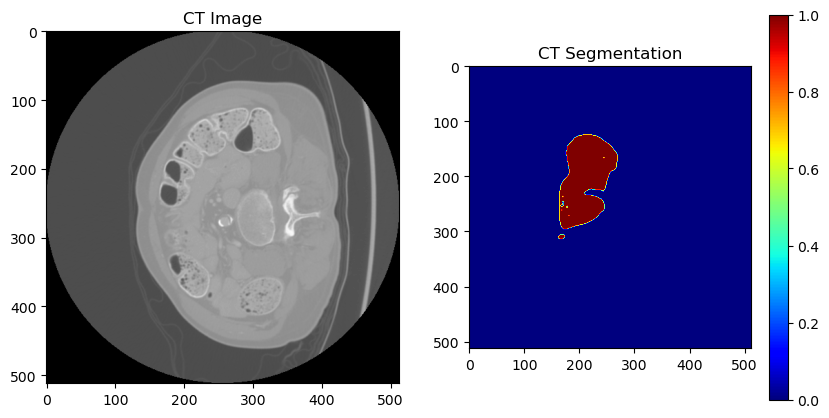

In [15]:
slice_idx =60

# Sample a slice from the image
CT_slice = image[0, 0, :, :, slice_idx].cpu()

# Get the maximum segmentation class for each pixel in the slice
CT_seg_slice = seg[0,0, :, :, slice_idx].cpu()

print(CT_slice.shape, CT_seg_slice.shape)

# Plot the image and segmentation slice as a subplot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(CT_slice, cmap="gray")
axes[0].set_title("CT Image")
axes[1].imshow(CT_seg_slice, cmap="jet")
axes[1].set_title("CT Segmentation")
plt.colorbar(mappable=axes[1].imshow(CT_seg_slice, cmap='jet'), ax=axes[1])
plt.show()

In [16]:
import torch
print(torch.cuda.is_available())

# Set the device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

True


In [17]:
from monai.networks.nets import SwinUNETR

# Create a Swin-UNet model
model = SwinUNETR(img_size=(512, 512, 64), in_channels=1, out_channels=5, use_v2 = True)

In [18]:
# Set the model to use the GPU
model = model.to(device)

# Set the hyperparameters for training
max_epochs = 10
learning_rate = 1e-3
weight_decay = 1e-5
val_interval = 1
checkpoint_dir = "./runs"

# Set the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
loss_function = torch.nn.CrossEntropyLoss()

# Create the training loop

# Set the model to training mode
model.train()

# Iterate over the training data for the specified number of epochs
for epoch in range(max_epochs):
    for batch in train_loader:
        # Extract the image and segmentation from the batch
        image, seg = batch["image"].to(device), batch["seg"].to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(image)
        
        # Compute the loss
        loss = loss_function(output, seg)
        
        # Backward pass
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
    # Print the loss for each epoch
    print(f"Epoch [{epoch+1}/{max_epochs}], Loss: {loss.item():.4f}")
    
    # Set the model to evaluation mode
    model.eval()
    
    # Compute the validation loss
    with torch.no_grad():
        for batch in test_loader:
            image, seg = batch["image"].to(device), batch["seg"].to(device)
            output = model(image)
            loss = loss_function(output, seg)
        print(f"Validation Loss: {loss.item():.4f}")

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.00 GiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 8.55 GiB is allocated by PyTorch, and 44.94 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)